In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from dateutil import relativedelta
import calendar
import matplotlib.pyplot as plt
from matplotlib import style
from scipy import stats
from statsmodels.tsa.stattools import grangercausalitytests
import statsmodels.api as sm
from datetime import datetime, timedelta
from dateutil import relativedelta
import calendar
import math

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def generate_data(formation_date, data_universe, equity_data, bond_data, fama_data, TMT):
    if data_universe == 'IG':
        universe = ['AAA', 'AA', 'A', 'BBB']
    elif data_universe == 'HY':
        universe = ['BB', 'B', 'CCC', 'CC']
    else:
        universe = [data_universe]
    
    #bond
    form_date = datetime.strptime(formation_date, '%Y-%m-%d')
    bcheck_last_day = calendar.monthrange(form_date.year, form_date.month)
    form_date = datetime(form_date.year, form_date.month, bcheck_last_day[-1])
    limitf_date =  form_date + relativedelta.relativedelta(months = 12)
    
    bond_data_ = bond_data[(bond_data.DATE >= form_date) & (bond_data.DATE <= limitf_date) & (bond_data.TMT >= TMT)]
    bond_data_ = bond_data_[bond_data_.RATING_CAT.isin(universe)]
    
    bond_data_ = bond_data_.reset_index()
    bond_data_['form_date'] = form_date
    bond_data_['month'] = (bond_data_.DATE.dt.year - bond_data_.form_date.dt.year)*12 + (bond_data_.DATE.dt.month - bond_data_.form_date.dt.month)
    bcom_list = np.sort(bond_data_[bond_data_['month'] == 1].dropna(subset=['RET_EOM', 'DURATION'])['company_symbol'].unique())
    
    #equity  
    avg_date =  form_date - relativedelta.relativedelta(months = 12)
    #limitavg_date =  form_date + relativedelta.relativedelta(months = 12)
    echeck_last_day = calendar.monthrange(avg_date.year, avg_date.month)
    avg_date = datetime(avg_date.year, avg_date.month, echeck_last_day[-1])
    
    equity_data_ = equity_data[(equity_data.date > avg_date) & (equity_data.date <= form_date)]
    equity_data_ = equity_data_.drop_duplicates()
    equity_data_['month_count'] = equity_data_.date.dt.month
    equity_sum_month = equity_data_.groupby('TICKER').agg({'month_count':'count'})
    
    equity_data_ = equity_data_[equity_data_.TICKER.isin(equity_sum_month[equity_sum_month.month_count == 12].index.values)]
       
    equity_data__ = equity_data_[equity_data_.TICKER.isin(bcom_list)]
    ecom_list = np.sort(equity_data__.TICKER.unique())
    
    bond_data__ = bond_data_[bond_data_.company_symbol.isin(ecom_list)]
    
    #fama
    fama_data['dateem'] = pd.to_datetime(pd.PeriodIndex(fama_data.dateff, freq='M').strftime('%Y-%m-%d'), format = '%Y-%m-%d') 
        
    bond_data___ = pd.merge(bond_data__, fama_data[['dateem', 'rf']], how='left', left_on = ['DATE'], right_on=['dateem'])
    bond_data___.YIELD = bond_data___.YIELD.str.replace('%', '').astype('float').divide(100.0)
    bond_data___.RET_EOM = bond_data___.RET_EOM.str.replace('%', '').astype('float').divide(100.0)
    
    equity_data___ = pd.merge(equity_data__, fama_data[['dateff', 'rf']], how='left', left_on = ['date'], right_on=['dateff'])

    return(equity_data___, bond_data___)

In [9]:
def avg_rolling_test(formation_date, data_universe, avg_range, test_period, TMT = 1):

    if data_universe == 'IG':
        universe = ['AAA', 'AA', 'A', 'BBB']
    elif data_universe == 'HY':
        universe = ['BB', 'B', 'CCC', 'CC']
    else:
        universe = [data_universe]
    
    #bond
    form_date = datetime.strptime(formation_date, '%Y-%m-%d')
    bcheck_last_day = calendar.monthrange(form_date.year, form_date.month)
    form_date = datetime(form_date.year, form_date.month, bcheck_last_day[-1])
    limitf_date =  form_date + relativedelta.relativedelta(months = test_period)
    
    bond_data_ = bond_data_raw[(bond_data_raw.DATE >= form_date) & (bond_data_raw.DATE <= limitf_date) & (bond_data_raw.TMT >= TMT)]
    bond_data_ = bond_data_[bond_data_.RATING_CAT.isin(universe)]
    
    bond_data_ = bond_data_.reset_index()
    bond_data_['form_date'] = form_date
    bond_data_['month'] = (bond_data_.DATE.dt.year - bond_data_.form_date.dt.year)*12 + (bond_data_.DATE.dt.month - bond_data_.form_date.dt.month)
    bcom_list = np.sort(bond_data_[bond_data_['month'] == 1].dropna(subset=['RET_EOM', 'DURATION'])['company_symbol'].unique())
    
    #equity  
    avg_date =  form_date - relativedelta.relativedelta(months = 24)
    echeck_last_day = calendar.monthrange(avg_date.year, avg_date.month)
    avg_date = datetime(avg_date.year, avg_date.month, echeck_last_day[-1])
    
    equity_data_ = equity_data_raw[(equity_data_raw.date > avg_date) & (equity_data_raw.date <= limitf_date)]
    equity_data_ = equity_data_.drop_duplicates()
    try:
        equity_data_ = equity_data_[equity_data_.RETX != 'C']
        equity_data_ = equity_data_[equity_data_.RETX != 'B']
    except:
        print('There is no C or B')
    equity_data_.RETX = equity_data_.RETX.astype('float64')
    equity_data_.RET = equity_data_.RET.astype('float64')
    
    equity_data_['month_count'] = equity_data_.date.dt.month
    equity_sum_month = equity_data_.groupby('TICKER').agg({'month_count':'count'})
    
    diff_month = (limitf_date.month - avg_date.month) + (limitf_date.year - avg_date.year)*12
    
    equity_data_ = equity_data_[equity_data_.TICKER.isin(equity_sum_month[equity_sum_month.month_count == diff_month].index.values)]
       
    equity_data__ = equity_data_[equity_data_.TICKER.isin(bcom_list)]
    ecom_list = np.sort(equity_data__.TICKER.unique())
    
    bond_data__ = bond_data_[bond_data_.company_symbol.isin(ecom_list)]
    
    equity_port = equity_data__.groupby(['date']).agg({'RETX': 'mean'})
    equity_port['bdate'] = pd.to_datetime([datetime(i.year, i.month, calendar.monthrange(i.year, i.month)[-1]) for i in equity_port.index])
    
    equity_port['rm_{0}'.format(avg_range[0])] = pd.rolling_mean(equity_port['RETX'], window = avg_range[0])
    equity_port['rm_{0}'.format(avg_range[1])] = pd.rolling_mean(equity_port['RETX'], window = avg_range[1])
    equity_port['rm_{0}'.format(avg_range[2])] = pd.rolling_mean(equity_port['RETX'], window = avg_range[2])
    
    equity_port = equity_port.dropna()
    
    bond_data___ = bond_data__.dropna(subset=['RET_EOM'])
    
    bond_data___.RET_EOM = bond_data___.RET_EOM.str.replace('%', '').astype('float').divide(100.0)
    bond_port = bond_data___.groupby(['DATE']).agg({'RET_EOM': 'mean'})
    
    equity_test = equity_port[['rm_{0}'.format(avg_range[0]), 'rm_{0}'.format(avg_range[1]), 'rm_{0}'.format(avg_range[2])]]
    equity_test.index = equity_port.bdate
    equity_test = equity_test[equity_test.index >= form_date]
    bond_test = bond_port
    
    data_test = equity_test.merge(bond_test, left_index=True, right_index=True)
    data_test['Ret_lag1'] = data_test['RET_EOM'].shift(1)
    data_test['Ret_lag2'] = data_test['RET_EOM'].shift(2)
    data_test['Ret_lag3'] = data_test['RET_EOM'].shift(3)
    data_test['Ret_lag4'] = data_test['RET_EOM'].shift(4)
    data_test['Ret_lag5'] = data_test['RET_EOM'].shift(5)
    data_test['Ret_lag6'] = data_test['RET_EOM'].shift(6)
    data_test['Ret_lag7'] = data_test['RET_EOM'].shift(7)
    data_test['Ret_lag8'] = data_test['RET_EOM'].shift(8)
    data_test['Ret_lag9'] = data_test['RET_EOM'].shift(9)
    data_test['Ret_lag10'] = data_test['RET_EOM'].shift(10)
    data_test['Ret_lag11'] = data_test['RET_EOM'].shift(11)
    data_test['Ret_lag12'] = data_test['RET_EOM'].shift(12)
    corr_test = data_test
    corr_test = corr_test.dropna()
    
    corr_result = corr_test.corr().iloc[3:16,0:3]
    corr_index = corr_result.index.values
    corr_index[0] = 'Ret_lag0'
    corr_result.index = corr_index
    corr_result.columns = ['Rolling_{0}'.format(avg_range[0]), 'Rolling_{0}'.format(avg_range[1]), 'Rolling_{0}'.format(avg_range[2])]
    
    result_ggc = pd.DataFrame(columns = ['Rolling_{0}'.format(avg_range[0]), 'Rolling_{0}'.format(avg_range[1]), 'Rolling_{0}'.format(avg_range[2])],
                              index = ['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Lag6', 'Lag7', 'Lag8',
                                       'Lag9', 'Lag10', 'Lag11', 'Lag12'])
    
    ggc3_test = grangercausalitytests(data_test[['rm_{0}'.format(avg_range[0]), 'RET_EOM']], maxlag = 12, verbose=False)
    ggc3_list = []
    for i in range(1, 13):
        ggc3_list.append([i, ggc3_test[i][0]['params_ftest'][1]])
    
    result_ggc['Rolling_{0}'.format(avg_range[0])] = [i[1] for i in ggc3_list]
    
    ggc6_test = grangercausalitytests(data_test[['rm_{0}'.format(avg_range[1]), 'RET_EOM']], maxlag = 12, verbose=False)
    ggc6_list = []
    for i in range(1, 13):
        ggc6_list.append([i, ggc6_test[i][0]['params_ftest'][1]])
    
    result_ggc['Rolling_{0}'.format(avg_range[1])] = [i[1] for i in ggc6_list]
    
    ggc12_test = grangercausalitytests(data_test[['rm_{0}'.format(avg_range[2]), 'RET_EOM']], maxlag = 12, verbose=False)
    ggc12_list = []
    for i in range(1, 13):
        ggc12_list.append([i, ggc12_test[i][0]['params_ftest'][1]])
    
    result_ggc['Rolling_{0}'.format(avg_range[2])] = [i[1] for i in ggc12_list]

    return(corr_result, result_ggc)

In [96]:
def avg_rolling_ml_test(formation_date, data_universe, avg_range, test_period, holding_period=1, TMT = 1):
    
    if data_universe == 'IG':
        universe = ['AAA', 'AA', 'A', 'BBB']
    elif data_universe == 'HY':
        universe = ['BB', 'B', 'CCC', 'CC']
    else:
        universe = [data_universe]
    
    #bond
    form_date = datetime.strptime(formation_date, '%Y-%m-%d')
    bcheck_last_day = calendar.monthrange(form_date.year, form_date.month)
    form_date = datetime(form_date.year, form_date.month, bcheck_last_day[-1])
    limitf_date =  form_date + relativedelta.relativedelta(months = test_period)
    
    bond_data_ = bond_data_raw[(bond_data_raw.DATE >= form_date) & (bond_data_raw.DATE <= limitf_date) & (bond_data_raw.TMT >= TMT)]
    bond_data_ = bond_data_[bond_data_.RATING_CAT.isin(universe)]
    
    bond_data_ = bond_data_.reset_index()
    bond_data_['form_date'] = form_date
    bond_data_['month'] = (bond_data_.DATE.dt.year - bond_data_.form_date.dt.year)*12 + (bond_data_.DATE.dt.month - bond_data_.form_date.dt.month)
    bcom_list = np.sort(bond_data_[bond_data_['month'] == 1].dropna(subset=['RET_EOM', 'DURATION'])['company_symbol'].unique())
    
    #equity  
    avg_date =  form_date - relativedelta.relativedelta(months = 24)
    echeck_last_day = calendar.monthrange(avg_date.year, avg_date.month)
    avg_date = datetime(avg_date.year, avg_date.month, echeck_last_day[-1])
    
    equity_data_ = equity_data_raw[(equity_data_raw.date > avg_date) & (equity_data_raw.date <= limitf_date)]
    equity_data_ = equity_data_.drop_duplicates()
    try:
        equity_data_ = equity_data_[equity_data_.RETX != 'C']
        equity_data_ = equity_data_[equity_data_.RETX != 'B']
    except:
        print('There is no C or B')
    equity_data_.RETX = equity_data_.RETX.astype('float64')
    equity_data_.RET = equity_data_.RET.astype('float64')
    
    equity_data_['month_count'] = equity_data_.date.dt.month
    equity_sum_month = equity_data_.groupby('TICKER').agg({'month_count':'count'})
    
    diff_month = (limitf_date.month - avg_date.month) + (limitf_date.year - avg_date.year)*12
    
    equity_data_ = equity_data_[equity_data_.TICKER.isin(equity_sum_month[equity_sum_month.month_count == diff_month].index.values)]
       
    equity_data__ = equity_data_[equity_data_.TICKER.isin(bcom_list)]
    ecom_list = np.sort(equity_data__.TICKER.unique())
    
    bond_data__ = bond_data_[bond_data_.company_symbol.isin(ecom_list)]
    
    equity_port = equity_data__.groupby(['date']).agg({'RETX': 'mean'})
    equity_port['bdate'] = pd.to_datetime([datetime(i.year, i.month, calendar.monthrange(i.year, i.month)[-1]) for i in equity_port.index])
    
    equity_port['rm_{0}'.format(avg_range[0])] = pd.rolling_mean(equity_port['RETX'], window = avg_range[0])
    equity_port['rm_{0}'.format(avg_range[1])] = pd.rolling_mean(equity_port['RETX'], window = avg_range[1])
    equity_port['rm_{0}'.format(avg_range[2])] = pd.rolling_mean(equity_port['RETX'], window = avg_range[2])
    
    equity_port = equity_port.dropna()
    
    bond_data___ = bond_data__.dropna(subset=['RET_EOM'])
    
    bond_data___.RET_EOM = bond_data___.RET_EOM.str.replace('%', '').astype('float').divide(100.0)
    bond_port = bond_data___.groupby(['DATE']).agg({'RET_EOM': 'mean'})
    
    equity_test = equity_port[['rm_{0}'.format(avg_range[0]), 'rm_{0}'.format(avg_range[1]), 'rm_{0}'.format(avg_range[2])]]
    equity_test.index = equity_port.bdate
    equity_test = equity_test[equity_test.index >= form_date]
    bond_test = bond_port
    
    data_test = equity_test.merge(bond_test, left_index=True, right_index=True)
    data_test['Ret_lag1'] = data_test['RET_EOM'].shift(1)
    data_test['Ret_lag2'] = data_test['RET_EOM'].shift(2)
    data_test['Ret_lag3'] = data_test['RET_EOM'].shift(3)
    data_test['Ret_lag4'] = data_test['RET_EOM'].shift(4)
    data_test['Ret_lag5'] = data_test['RET_EOM'].shift(5)
    data_test['Ret_lag6'] = data_test['RET_EOM'].shift(6)
    data_test['Ret_lag7'] = data_test['RET_EOM'].shift(7)
    data_test['Ret_lag8'] = data_test['RET_EOM'].shift(8)
    data_test['Ret_lag9'] = data_test['RET_EOM'].shift(9)
    data_test['Ret_lag10'] = data_test['RET_EOM'].shift(10)
    data_test['Ret_lag11'] = data_test['RET_EOM'].shift(11)
    data_test['Ret_lag12'] = data_test['RET_EOM'].shift(12)
    
    data_test_ = data_test.dropna()

    from sklearn.feature_selection import RFE
    from sklearn.linear_model import LinearRegression
    from sklearn.linear_model import Ridge
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.ensemble import ExtraTreesRegressor
    from sklearn.preprocessing import StandardScaler
    import xgboost as xgb
    from xgboost import XGBRegressor
    
    scaler = StandardScaler()
    df_ml_test = pd.DataFrame(columns=['Lag1', 'Lag2', 'Lag3', 'Lag4'])
    X = data_test_.iloc[:,4:8].values 
    
    model_name = ['LinearRegression()', 'Ridge(alpha=1.0)', 
             'RandomForestRegressor(max_depth=1000, random_state=0, n_estimators=100)', 
             'ExtraTreesRegressor(max_depth=1000, random_state=0,n_estimators=100)',
             'XGBRegressor(max_depth=1000, random_state=0, n_estimators=100)']
        
    
    for i in range(0, 3):
        y = data_test_.iloc[:, i].values
        
        df_lm_temp = pd.DataFrame(columns=['Lag1', 'Lag2', 'Lag3', 'Lag4'], index=range(0, 5))
        index_name = ['LinearRegression_{0}'.format(avg_range[i]), 'RidgeRegression_{0}'.format(avg_range[i]),
                      'RandomForest_{0}'.format(avg_range[i]), 'ExtraTrees_{0}'.format(avg_range[i]), 
                      'XGBoost_{0}'.format(avg_range[i])]
        
        for j in range(0, 5):
            model = model_name[j]
            rfe = RFE(eval(model), holding_period)
            rfe = rfe.fit(scaler.fit_transform(X), y)
            df_lm_temp.iloc[j, :] = rfe.ranking_
            
        df_lm_temp.index = index_name
        df_ml_test = df_ml_test.append(df_lm_temp)
    
    return(df_ml_test)

In [5]:
bond_data_raw = pd.read_csv('bond_data.txt', sep='\t')
bond_data_raw.DATE = pd.to_datetime(bond_data_raw.DATE, format = '%d%b%Y')

equity_data_raw = pd.read_csv('equity_data.txt', sep='\t')
equity_data_raw.date = pd.to_datetime(equity_data_raw.date, format = '%Y%m%d')

fama_data_raw = pd.read_csv('fama_data.txt', sep='\t')
fama_data_raw.dateff = pd.to_datetime(fama_data_raw.dateff, format = '%Y%m%d')

In [6]:
formation_date = '2009-12-31'
strat_type = 0
holding_range = (0, 1)
TMT = 1
avg_range = (3, 6, 12)
test_period = 12*7

# IG universe

In [91]:
data_universe = 'IG'

In [10]:
corr_test_IG, ggc_test_IG = avg_rolling_test(formation_date, data_universe, avg_range, test_period)

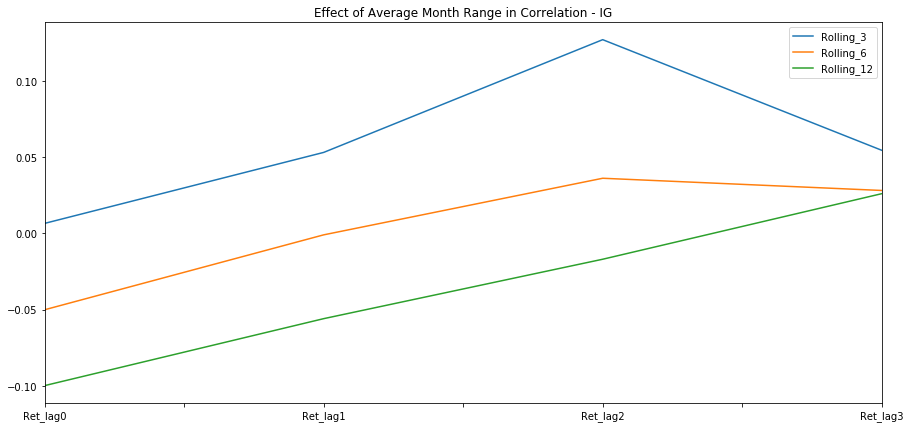

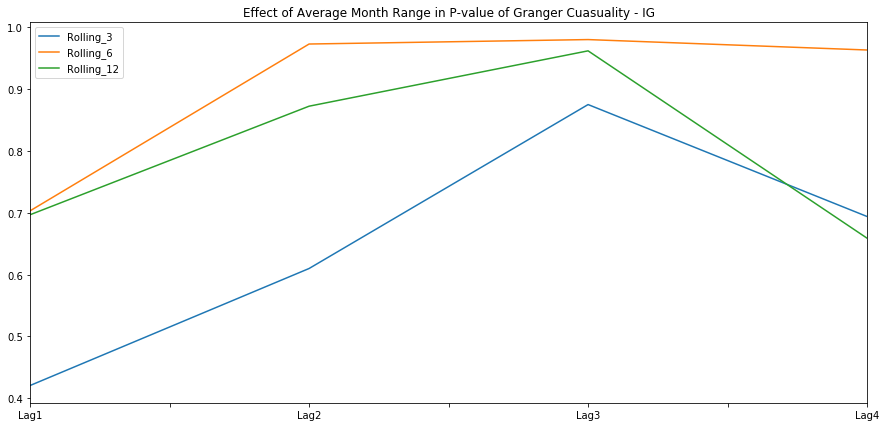

In [11]:
corr_test_IG.iloc[0:4,:].plot(figsize=(15, 7), title ='Effect of Average Month Range in Correlation - {0}'.format(data_universe))
ggc_test_IG.iloc[0:4,:].plot(figsize=(15, 7), title ='Effect of Average Month Range in P-value of Granger Cuasuality - {0}'.format(data_universe))

In [97]:
ml_test_IG = avg_rolling_ml_test(formation_date, data_universe, avg_range, test_period, holding_period=1)
ml_test_IG

,Lag1,Lag2,Lag3,Lag4
LinearRegression_3,4.0,1.0,3.0,2.0
RidgeRegression_3,4.0,1.0,3.0,2.0
RandomForest_3,4.0,2.0,1.0,3.0
ExtraTrees_3,3.0,1.0,4.0,2.0
XGBoost_3,2.0,3.0,1.0,4.0
LinearRegression_6,4.0,1.0,2.0,3.0
RidgeRegression_6,4.0,1.0,2.0,3.0
RandomForest_6,4.0,1.0,3.0,2.0
ExtraTrees_6,3.0,4.0,2.0,1.0
XGBoost_6,1.0,2.0,3.0,4.0


In [98]:
ml_test_IG = avg_rolling_ml_test(formation_date, data_universe, avg_range, test_period, holding_period=3)
ml_test_IG

,Lag1,Lag2,Lag3,Lag4
LinearRegression_3,2.0,1.0,1.0,1.0
RidgeRegression_3,2.0,1.0,1.0,1.0
RandomForest_3,2.0,1.0,1.0,1.0
ExtraTrees_3,1.0,1.0,2.0,1.0
XGBoost_3,1.0,1.0,1.0,2.0
LinearRegression_6,2.0,1.0,1.0,1.0
RidgeRegression_6,2.0,1.0,1.0,1.0
RandomForest_6,2.0,1.0,1.0,1.0
ExtraTrees_6,1.0,2.0,1.0,1.0
XGBoost_6,1.0,1.0,1.0,2.0


# BBB

In [99]:
data_universe = 'BBB'

In [15]:
corr_test_BBB, ggc_test_BBB = avg_rolling_test(formation_date, data_universe, avg_range, test_period)

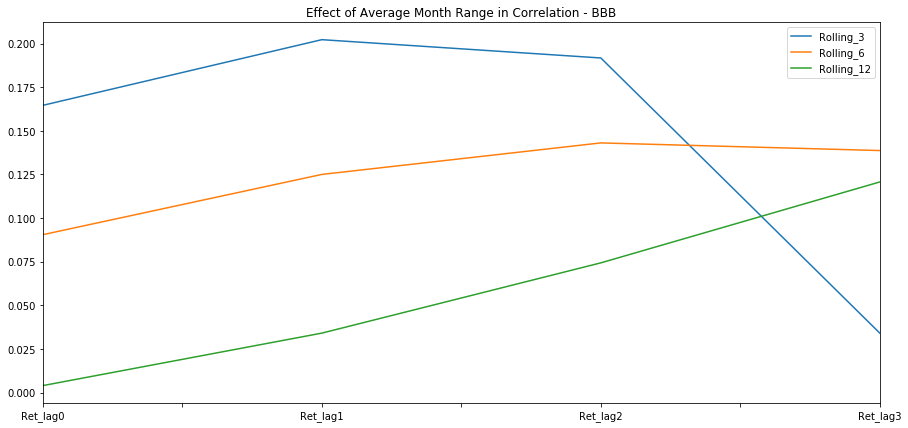

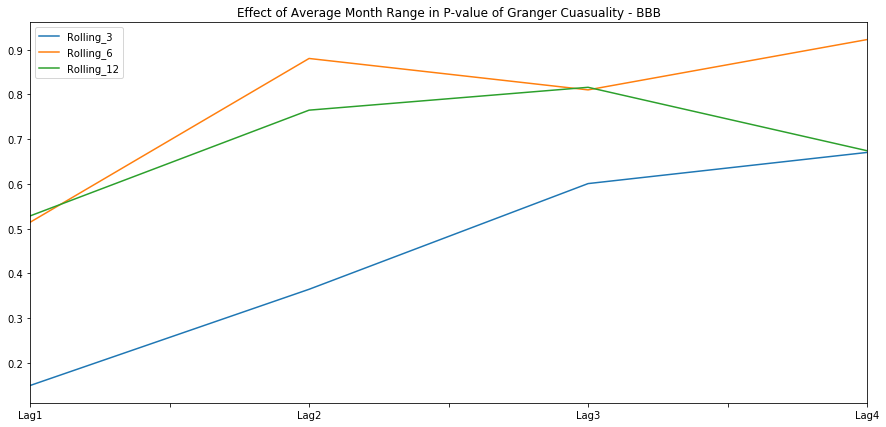

In [16]:
corr_test_BBB.iloc[0:4,:].plot(figsize=(15, 7), title ='Effect of Average Month Range in Correlation - {0}'.format(data_universe))
ggc_test_BBB.iloc[0:4,:].plot(figsize=(15, 7), title ='Effect of Average Month Range in P-value of Granger Cuasuality - {0}'.format(data_universe))

In [100]:
ml_test_BBB = avg_rolling_ml_test(formation_date, data_universe, avg_range, test_period, holding_period = 1)
ml_test_BBB

,Lag1,Lag2,Lag3,Lag4
LinearRegression_3,1.0,2.0,4.0,3.0
RidgeRegression_3,1.0,2.0,4.0,3.0
RandomForest_3,1.0,3.0,4.0,2.0
ExtraTrees_3,1.0,3.0,4.0,2.0
XGBoost_3,1.0,2.0,3.0,4.0
LinearRegression_6,4.0,1.0,3.0,2.0
RidgeRegression_6,4.0,1.0,3.0,2.0
RandomForest_6,2.0,3.0,4.0,1.0
ExtraTrees_6,2.0,3.0,4.0,1.0
XGBoost_6,1.0,2.0,4.0,3.0


In [101]:
ml_test_BBB = avg_rolling_ml_test(formation_date, data_universe, avg_range, test_period, holding_period = 3)
ml_test_BBB

,Lag1,Lag2,Lag3,Lag4
LinearRegression_3,1.0,1.0,2.0,1.0
RidgeRegression_3,1.0,1.0,2.0,1.0
RandomForest_3,1.0,1.0,2.0,1.0
ExtraTrees_3,1.0,1.0,2.0,1.0
XGBoost_3,1.0,1.0,1.0,2.0
LinearRegression_6,2.0,1.0,1.0,1.0
RidgeRegression_6,2.0,1.0,1.0,1.0
RandomForest_6,1.0,1.0,2.0,1.0
ExtraTrees_6,1.0,1.0,2.0,1.0
XGBoost_6,1.0,1.0,2.0,1.0


# IG universe

In [102]:
data_universe = 'HY'

In [19]:
corr_test_HY, ggc_test_HY = avg_rolling_test(formation_date, data_universe, avg_range, test_period)

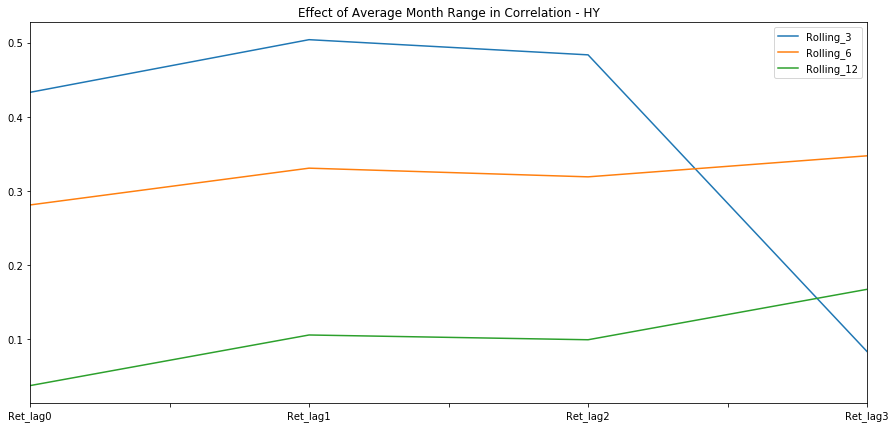

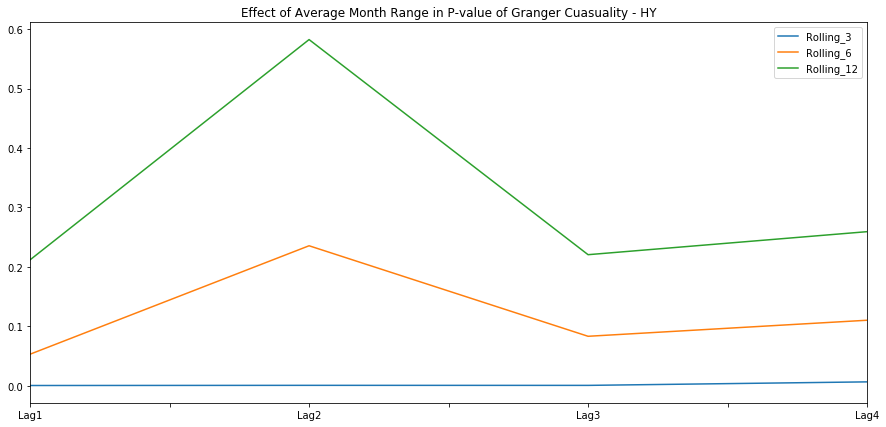

In [20]:
corr_test_HY.iloc[0:4,:].plot(figsize=(15, 7), title ='Effect of Average Month Range in Correlation - {0}'.format(data_universe))
ggc_test_HY.iloc[0:4,:].plot(figsize=(15, 7), title ='Effect of Average Month Range in P-value of Granger Cuasuality - {0}'.format(data_universe))

In [21]:
ggc_test_HY

,Rolling_3,Rolling_6,Rolling_12
Lag1,0.000381,0.053048,0.211814
Lag2,0.000654,0.235501,0.582406
Lag3,0.000594,0.083188,0.220484
Lag4,0.006493,0.110194,0.259208
Lag5,0.005607,0.136352,0.080665
Lag6,0.019980,0.029579,0.101727
Lag7,0.018522,0.142854,0.140494
Lag8,0.001404,0.008305,0.054868
Lag9,0.002129,0.001159,0.028320
Lag10,0.016348,0.001986,0.009010


In [103]:
ml_test_HY = avg_rolling_ml_test(formation_date, data_universe, avg_range, test_period, holding_period = 1)
ml_test_HY

,Lag1,Lag2,Lag3,Lag4
LinearRegression_3,1.0,2.0,4.0,3.0
RidgeRegression_3,1.0,2.0,4.0,3.0
RandomForest_3,1.0,2.0,4.0,3.0
ExtraTrees_3,1.0,2.0,4.0,3.0
XGBoost_3,1.0,2.0,4.0,3.0
LinearRegression_6,2.0,4.0,1.0,3.0
RidgeRegression_6,2.0,4.0,1.0,3.0
RandomForest_6,1.0,2.0,3.0,4.0
ExtraTrees_6,1.0,2.0,3.0,4.0
XGBoost_6,1.0,2.0,4.0,3.0


In [104]:
ml_test_HY = avg_rolling_ml_test(formation_date, data_universe, avg_range, test_period, holding_period = 3)
ml_test_HY

,Lag1,Lag2,Lag3,Lag4
LinearRegression_3,1.0,1.0,2.0,1.0
RidgeRegression_3,1.0,1.0,2.0,1.0
RandomForest_3,1.0,1.0,2.0,1.0
ExtraTrees_3,1.0,1.0,2.0,1.0
XGBoost_3,1.0,1.0,2.0,1.0
LinearRegression_6,1.0,2.0,1.0,1.0
RidgeRegression_6,1.0,2.0,1.0,1.0
RandomForest_6,1.0,1.0,1.0,2.0
ExtraTrees_6,1.0,1.0,1.0,2.0
XGBoost_6,1.0,1.0,2.0,1.0
